In [ ]:
%pip install --upgrade gpudb==7.2.0.1 pandas pyarrow typeguard langchain langchain_openai nemollm colorlog langchain-community

In [49]:
import gpudb

db = gpudb.GPUdb(host='https://demo72.kinetica.com/_gpudb',
                     username='gtc',
                     password='Kinetica123!')

# We want to have our own individual context to work with, so create an extension to the context name as shown here
extension = 'amparo'

sqlcontext = f'''CREATE OR REPLACE CONTEXT nyse.nyse_report_ctxt_{extension}
(
    TABLE = nyse.prices,
    COMMENT = 'Stock prices including ask, bid, and sale price and size',
    RULES = (
        'when I ask about stock prices, use the nyse.prices table',
        'when I ask about stock prices today, filter on all results that occurred between now and an interval of 1 day',
        'all stock symbols are in lower case',
        'when I ask about today I mean that the timestamp should be greater than or equal to now minus an interval of 1 day',
        'when I ask about any column, make sure there are no null values or NaN values',
        'replace all NaN values with 0 using the IFNAN() function',
        'all numeric results should be larger than 0',
        'convert all stock symbols to lower case',
        'always filter out null values'
    ),
    COMMENTS = (
        'ap' = 'ask price',
        'bp' = 'bid price',
        'bs' = 'bid size',
        'lp' = 'sale price',
        'ls' = 'sale size',
        's' = 'symbol',
        't' = 'timestamp'
    )
),
(
    TABLE = nyse.vector_week,
    COMMENT = 'Time-series vector embeddings for NYSE stock characteristics spanning 1 week intervals'
),
(
    SAMPLES = (
'find similar patterns to tsco for the previous week' = 'SELECT
    ts_bkt,
    symbol,
    l1_distance(ap_vec,(select string(ap_vec) from (select * from nyse.vector_week where ts_bkt = date_trunc(week, now() - interval 1 week) and symbol = ''tsco'' limit 1))) as d1
FROM
    (select * from nyse.vector_week where ts_bkt = date_trunc(week, now() - interval 1 week)) filtered
ORDER BY
    d1 asc
LIMIT
    5;',
'Show me a top 5 list of stocks from today whose value increased by at least 12%' = 'SELECT
    s,
    price_increase_percentage
FROM
    (
        SELECT
            s,
            LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt) AS previous_sale_price,
            (((weekly.max_price - LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) / LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) * 100) AS price_increase_percentage
        FROM 
            (select
                date(date_trunc(week, t)) as ts_bkt,
                s,
                min(lp) as min_price,
                max(lp) as max_price
            from
                nyse.prices
            where
                lp is not null
                and date(date_trunc(week, t)) >= date(date_trunc(week, now() - interval 7 day))
            group by
                1,2
            order by
                s, ts_bkt) weekly) AS PriceChanges
WHERE
    price_increase_percentage > 12
ORDER BY
    price_increase_percentage desc
LIMIT 5;',
'Show me a top 5 list of stocks from today whose value decreased by at least 12%' = 'SELECT
    s,
    price_decrease_percentage
FROM
    (
        SELECT
            s,
            LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt) AS previous_sale_price,
            (((weekly.max_price - LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) / LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) * 100) * -1 AS price_decrease_percentage
        FROM 
            (select
                date(date_trunc(week, t)) as ts_bkt,
                s,
                min(lp) as min_price,
                max(lp) as max_price
            from
                nyse.prices
            where
                lp is not null
                and date(date_trunc(week, t)) >= date(date_trunc(week, now() - interval 7 day))
            group by
                1,2
            order by
                s, ts_bkt) weekly) AS PriceChanges
WHERE
    price_decrease_percentage > 12
ORDER BY
    price_decrease_percentage desc
LIMIT 5;'
    )
)
    '''
db.execute_sql(sqlcontext)

{'count_affected': 1,
 'response_schema_str': '{"name":"generic_response","type":"record","fields":[{"name":"column_1","type":{"type":"array","items":"string"}},{"name":"column_headers","type":{"type":"array","items":"string"}},{"name":"column_datatypes","type":{"type":"array","items":"string"}}]}',
 'binary_encoded_response': b'\x00\x02\ndummy\x00\x02\x0cstring\x00',
 'json_encoded_response': '',
 'total_number_of_records': -1,
 'has_more_records': False,
 'paging_table': '',
 'info': {'X-Kinetica-Group': 'DDL',
  'count': '0',
  'last_endpoint': '/create/context/internal',
  'total_number_of_records': '0'},
 'status_info': {'status': 'OK',
  'message': '',
  'data_type': 'execute_sql_response',
  'response_time': 0.0168},
 'record_type': kinetica.protocol.RecordType('', [('dummy', 'string')])}

In [83]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.chat_models.kinetica import ChatKinetica, KineticaSqlOutputParser, KineticaSqlResponse, KineticaUtil
from IPython.display import display, HTML

# create the Kinetica connection
kdbc = KineticaUtil.create_kdbc(url="https://demo72.kinetica.com/_gpudb", user="gtc", passwd="Kinetica123!")

# create the Kinetica LLM
kinetica_llm = ChatKinetica(kdbc=kdbc)

# Set the context to use
kinetica_ctx = f'nyse.nyse_report_ctxt_{extension}'

In [84]:
# load the context from the database
ctx_messages = kinetica_llm.load_messages_from_context(kinetica_ctx)

# Add the input prompt. This is where input question will be substituted.
ctx_messages.append(("human", "{input}"))

# Create the prompt template.
prompt_template = ChatPromptTemplate.from_messages(ctx_messages)
prompt_template.pretty_print()

# create the chain. 
# note: The KineticaSqlOutputParser will execute the SQL statement and is optional.
chain = prompt_template | kinetica_llm | KineticaSqlOutputParser(kdbc=kdbc)

================================ System Message ================================

CREATE TABLE nyse.prices AS
(
   t DATETIME NOT NULL COMMENT 'timestamp',
   s VARCHAR (8, dict, shard_key) NOT NULL COMMENT 'symbol',
   type VARCHAR (4, dict) NOT NULL,
   ap REAL  COMMENT 'ask price',
   as INTEGER,
   bp REAL  COMMENT 'bid price',
   bs INTEGER  COMMENT 'bid size',
   lp REAL  COMMENT 'sale price',
   ls INTEGER  COMMENT 'sale size'
);
COMMENT ON TABLE nyse.prices IS 'Stock prices including ask, bid, and sale price and size';
-- When querying table nyse.prices the following rules apply:
-- * when I ask about stock prices, use the nyse.prices table
-- * when I ask about stock prices today, filter on all results that occurred between now and an interval of 1 day
-- * all stock symbols are in lower case
-- * when I ask about today I mean that the timestamp should be greater than or equal to now minus an interval of 1 day
-- * when I ask about any column, make sure there are no null value

In [85]:
response: KineticaSqlResponse = chain.invoke({"input": '''show me a sample of the vector data'''})
display(HTML(response.dataframe.to_html(index=False)))

ts_bkt,symbol,ap_vec
2023-06-11,aaau,"[0.7810719, -2.1616833, 1.0, 0.0046902806, 19.233261, 1.8405352, -0.9047696, -0.37448904, 0.9782609, 2.0, 541.0, 0.47646618, 0.25454745, 0.8695652, 0.2826087, 0.37138253, 1.2640002, 0.14285715, 1.0096765, 4.0, 0.012704174, 3.0]"
2023-06-11,aac,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2023-06-11,aact+,"[0.0, 0.0, 0.0, 0.0, 0.36, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2023-06-11,aaic,"[0.7803834, -0.06278763, 3.0, 0.09323388, 4.504397, 0.27388838, -0.21686646, -0.39029485, 0.021276595, 3.0, 4.0, 1.705458, 0.06915564, 0.84615386, 0.15384616, 0.2830397, 1.1290098, 0.33333334, 1.1495441, 3.0, 0.19285715, 5.0]"
2023-06-11,aal,"[1.292521, -37.717945, 13.0, 0.0, 16.48949, 0.2140612, -7.2385406, -3.3611448, -0.68335664, 2.0, 4466.0, 1.1082165, 0.008230452, 0.66, 0.88, 0.4002872, 0.8107088, 0.0007698229, 0.84080994, 12.0, 0.0131774, 0.0]"


<Axes: xlabel='t'>

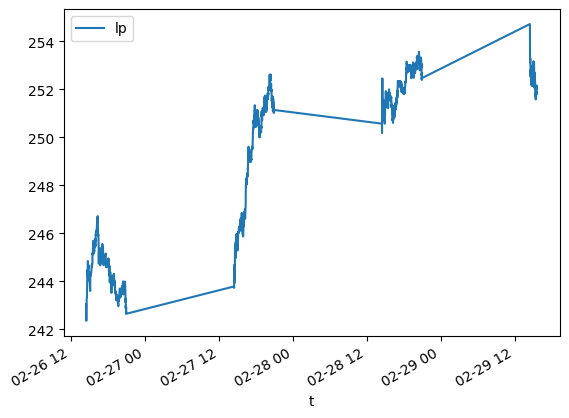

In [53]:
response: KineticaSqlResponse = chain.invoke({"input": '''show me all sale prices for tsco for the last week where the sale price is recorded'''})
response.dataframe.plot.line(x='t', y='lp')

In [86]:
import importlib
import kinetica.kineai_summarize

importlib.reload(kinetica.kineai_summarize)
kineticallm = kinetica.kineai_summarize.KineticaLLM(f'nyse.nyse_report_ctxt_{extension}')

INFO:SqlAssistLLM:Connected to http://172.31.33.30:9191. (version 7.2.0.1)


In [87]:
system = """ KineticAI is a cheerful AI assistant for engaging in a conversation between an LLM using the Nemo framework and the Kinetica LLM.  The Kinetica
LLM is designed to translate natural language questions into SQL queries. 

The SqlAssist AI will respond with an answer to the question in JSON format from SqlAssist.

Your job is to summarize multiple result sets in JSON form into a report suitable for a financial executive
"""
#firt 4 pair hwo to call Kinetika (this )
# Ilustrate this better where you have a bigger paragraph
# Have the content asnwer. 
context0 = [dict(role="system", content=system),
            dict(role="user", content='KineticaLLM |  [{"s": "tgl", "price_increase_percentage": 6817.68798828125}, {"s": "lyt", "price_increase_percentage": 6435.08740234375}, {"s": "phun", "price_increase_percentage": 5944.6015625}, {"s": "auud", "price_increase_percentage": 2182.05126953125}, {"s": "atnf", "price_increase_percentage": 1742.1053466796875}]'),
            dict(role="assistant", content='it appears that tgl went up 6817%, lyt went up by 6435%, phun went up by 5944%, auud went up by 2182%, and atnf went up by 1742%')]

In [88]:
question = 'show me the top 5 stocks that have increased in value by 12% or more in the last week with percentage increases'
out_ctxt = kineticallm.chat(context0, question)
display(out_ctxt)


INFO:SqlAssistLLM:Query: show me the top 5 stocks that have increased in value by 12% or more in the last week with percentage increases
INFO:SqlAssistLLM:SQL: SELECT
    s,
    price_increase_percentage
FROM
    (
        SELECT
            s,
            LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt) AS previous_sale_price,
            (((weekly.max_price - LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) / LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) * 100) AS price_increase_percentage
        FROM 
            (select
                date(date_trunc(week, t)) as ts_bkt,
                s,
                min(lp) as min_price,
                max(lp) as max_price
            from
                nyse.prices
            where
                lp is not null
                and date(date_trunc(week, t)) >= date(date_trunc(week, now() - interval 7 day))
            group by
                1,2
            order by
                s, ts_bkt) weekl

s,price_increase_percentage
tgl,6817.687988
lyt,6435.087402
phun,5944.601562
auud,2470.512939
atnf,1784.210449


In [76]:
question = 'show me the top 5 stocks that have decreased in value by 12% or more in the last week with percentage decreases'
out_ctxt = kineticallm.chat(context0, question)
display(out_ctxt)

INFO:SqlAssistLLM:Query: show me the top 5 stocks that have decreased in value by 12% or more in the last week with percentage decreases
INFO:SqlAssistLLM:SQL: SELECT
    s,
    price_decrease_percentage
FROM
    (
        SELECT
            s,
            LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt) AS previous_sale_price,
            (((weekly.max_price - LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) / LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) * 100) * -1 AS price_decrease_percentage
        FROM 
            (select
                date(date_trunc(week, t)) as ts_bkt,
                s,
                min(lp) as min_price,
                max(lp) as max_price
            from
                nyse.prices
            where
                lp is not null
                and date(date_trunc(week, t)) >= date(date_trunc(week, now() - interval 7 day))
            group by
                1,2
            order by
                s, ts_bkt) 

s,price_decrease_percentage
wmt,65.371597
acon,51.741184
htoow,42.857136
ccm,33.310383
pftaw,27.777779


In [82]:
percentage_change = 12
out_ctxt = kineticallm.report(context0, percentage_change)
print(out_ctxt)

INFO:SqlAssistLLM:Query: show me the top 5 stocks that have increased in value by 12% or more in the last week with percentage increases
INFO:SqlAssistLLM:SQL: SELECT
    s,
    price_increase_percentage
FROM
    (
        SELECT
            s,
            LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt) AS previous_sale_price,
            (((weekly.max_price - LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) / LAG(weekly.min_price) OVER (PARTITION BY s ORDER BY ts_bkt)) * 100) AS price_increase_percentage
        FROM 
            (select
                date(date_trunc(week, t)) as ts_bkt,
                s,
                min(lp) as min_price,
                max(lp) as max_price
            from
                nyse.prices
            where
                lp is not null
                and date(date_trunc(week, t)) >= date(date_trunc(week, now() - interval 7 day))
            group by
                1,2
            order by
                s, ts_bkt) weekl

The following is a summary of the JSON provided:

TOP 5 Gains:

- tgl: price_increase_percentage of 6817.68798828125
- lyt: price_increase_percentage of 6435.08740234375
- phun: price_increase_percentage of 5944.6015625
- auud: price_increase_percentage of 2470.512939453125
- atnf: price_increase_percentage of 1784.21044921875

TOP 5 Losses:

- wmt: price_decrease_percentage of 65.37159729003906
- acon: price_decrease_percentage of 51.74118423461914
- ccm: price_decrease_percentage of 33.31038284301758
- pftaw: price_decrease_percentage of 27.77777862548828
- abllw: price_decrease_percentage of 26.684280395507812

Please note that the summary is based on the provided JSON and may not be accurate or complete.
